# Comparison of Gene Prioritization Methods / Runs

## Objectives

This notebook compares multiple gene prioritization runs (tools, HPO versions, extraction strategies)
on the same cohort of patients with known causal genes.

The goals are to:
- assess global prioritization performance across runs
- compare robustness and failure modes
- evaluate the impact of phenotype quantity and quality
- identify strengths and weaknesses of each method

All analyses are performed at the **patient level**, using the rank of the known causal gene.


## Imports and global parameters

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 120)


## Loading data

In [2]:
# === PARAMÈTRE ===
ANALYSIS_TABLE_PATH = "../data/synthetic_variants.csv"  # ou .parquet
OUTPUT_PATH = "" 

# Chargement
if ANALYSIS_TABLE_PATH.endswith(".parquet"):
    df = pd.read_parquet(ANALYSIS_TABLE_PATH)
else:
    df = pd.read_csv(ANALYSIS_TABLE_PATH, sep=",")

print("Total rows:", len(df))
print("Runs:", df["run_id"].nunique())
print("Patients:", df["ID_PAT_ETUDE"].nunique())

df.head()

Total rows: 100
Runs: 2
Patients: 50


,ID_PAT_ETUDE,IPP,IPP_clef,key_for_chaining,transcript_from_ehop,transcript,transcript_no_version,chr,pos,ref,alt,var_id,transcript_nm,gene_symbol,gene_hgnc_id,acmg_classification,acmg_criteria,clinvar_classification,clinvar_review_status,run_id,prio_tool,hpo_version,extraction_method,report_path,report_found,report_read_error,report_read_error_msg,gene_found_in_report,gene_not_found_flag,gene_duplicated_in_report,rank,score,hpo_implicated,hpo_description_implicated,phenotype_specificity,top1,top3,top5,top10
0,report1,IPP000001,uSyL,report1,NM_368371.2,<function generate_row.<locals>.<lambda> at 0x11ce2c7c0>,<function generate_row.<locals>.<lambda> at 0x11ce2c860>,16,153257221,T,G,var1,NM_751304,FLNA,HGNC:3754,Pathogenic,"PVS1,PM2",Pathogenic,criteria_provided_single_submitter,phenogenius_hpo2022_sm,phenogenius,2022,string_matching,ext/phenogenius_results_analysis/data/fake_outputs/report1.tsv,True,False,NaN,True,False,False,3,1.28,"[{'HP:5003987': 0.23}, {'HP:8728518': 0.68}, {'HP:6511036': 0.84}, {'HP:3202901': 0.53}, {'HP:1263660': 0.3}, {'HP:6...","[{'New before certainly': 0.23}, {'Country success': 0.68}, {'Somebody consider officer': 0.84}, {'Once one thousand...",A - the reported phenotype is highly specific,True,False,False,False
1,report1,IPP000001,SmjB,report1,NM_451374.2,<function generate_row.<locals>.<lambda> at 0x11ce2c900>,<function generate_row.<locals>.<lambda> at 0x11ce2c9a0>,6,84445133,T,A,var1,NM_512054,MECP2,HGNC:6990,VUS,NaN,Pathogenic,criteria_provided_single_submitter,phen2gene_hpo_2022_sm,phen2gene,2022,string_matching,ext/phenogenius_results_analysis/data/fake_outputs/report1.tsv,True,False,NaN,True,False,False,386,6.90,"[{'HP:8871986': 0.86}, {'HP:9196434': 0.38}, {'HP:1352271': 0.57}, {'HP:1733844': 0.64}, {'HP:7835293': 0.64}, {'HP:...","[{'Ok top agree': 0.86}, {'Million crime house': 0.38}, {'Want fact': 0.57}, {'Defense record coach': 0.64}, {'Send ...",B - the reported phenotype is consistent,False,False,True,False
2,report2,IPP000002,vSyO,report2,NM_653432.1,<function generate_row.<locals>.<lambda> at 0x11ce2ca40>,<function generate_row.<locals>.<lambda> at 0x11ce2cae0>,13,177353912,T,T,var2,NM_225223,MECP2,HGNC:6990,Pathogenic,"PVS1,PM2",Likely_pathogenic,criteria_provided_single_submitter,phenogenius_hpo2022_sm,phenogenius,2022,string_matching,ext/phenogenius_results_analysis/data/fake_outputs/report2.tsv,True,False,NaN,True,False,False,159,2.72,"[{'HP:4245090': 0.64}, {'HP:8493338': 0.82}, {'HP:7561297': 0.45}, {'HP:2914398': 0.22}, {'HP:2041192': 0.69}, {'HP:...","[{'She child artist here': 0.64}, {'Something always possible': 0.82}, {'Wear stay hit': 0.45}, {'Range seem': 0.22}...",C - the phenotype is reported with limited association,True,True,True,True
3,report2,IPP000002,UYPV,report2,NM_967532.7,<function generate_row.<locals>.<lambda> at 0x11ce2cb80>,<function generate_row.<locals>.<lambda> at 0x11ce2cc20>,8,76848089,C,A,var2,NM_364815,COL1A1,HGNC:2197,Likely_pathogenic,"PS2,PM1",Pathogenic,criteria_provided_single_submitter,phen2gene_hpo_2022_sm,phen2gene,2022,string_matching,ext/phenogenius_results_analysis/data/fake_outputs/report2.tsv,True,False,NaN,True,False,False,395,3.39,"[{'HP:1195333': 0.59}, {'HP:2690852': 0.79}, {'HP:4735597': 0.66}, {'HP:7918039': 0.83}, {'HP:4811302': 0.47}, {'HP:...","[{'Meeting theory': 0.59}, {'Cover piece material shake': 0.79}, {'Cultural': 0.66}, {'Yet court': 0.83}, {'Old beli...",C - the phenotype is reported with limited association,False,True,False,False
4,report3,IPP000003,cWxu,report3,NM_191481.10,<function generate_row.<locals>.<lambda> at 0x11ce2ccc0>,<function generate_row.<locals>.<lambda> at 0x11ce2cd60>,22,152149030,C,T,var3,NM_456368,KMT2D,HGNC:7133,Pathogenic,"PVS1,PM2",Likely_pathogenic,criteria_provided_single_submitter,phenogenius_hpo2022_sm,phenogenius,2022,string_matching,ext/phenogenius_results_analysis/data/fake_outputs/report3.tsv,True,False,NaN,True,False,False,424,9.46,"[{'HP:2854799': 0.46}, {'HP:5769546': 0.54}, {'HP:479

## Verification of runs comparability

ensure that the runs are based on a comparable basis

In [3]:
run_summary = (
    df.groupby("run_id")
    .agg(
        n_rows=("ID_PAT_ETUDE", "count"),
        n_patients=("ID_PAT_ETUDE", "nunique"),
        reports_found=("report_found", "sum"),
        read_errors=("report_read_error", "sum"),
        gene_not_found=("gene_not_found_flag", "sum"),
    )
    .sort_values("n_patients", ascending=False)
)

run_summary


,n_rows,n_patients,reports_found,read_errors,gene_not_found
run_id,,,,,
phen2gene_hpo_2022_sm,50,50,50,0,0
phenogenius_hpo2022_sm,50,50,50,0,0


## Filtering usable lines

In [4]:
# Lignes exploitables pour l'évaluation du rang
eval_df = df[
    df["report_found"] &
    (~df["report_read_error"])
].copy()

print("Rows usable for evaluation:", len(eval_df))
print("Patients usable:", eval_df["ID_PAT_ETUDE"].nunique())


Rows usable for evaluation: 100
Patients usable: 50


## Construction of the median rank per patient and per run

In [5]:
rank_eval = (
    eval_df
    .groupby(["run_id", "ID_PAT_ETUDE"])
    .agg(
        avg_rank=("rank", "mean"),      # ou "min" si tu préfères
        phenotype_length=("hpo_implicated", lambda x: x.notna().sum())
    )
    .reset_index()
)

rank_eval.head()


,run_id,ID_PAT_ETUDE,avg_rank,phenotype_length
0,phen2gene_hpo_2022_sm,report1,386.0,1
1,phen2gene_hpo_2022_sm,report10,352.0,1
2,phen2gene_hpo_2022_sm,report11,284.0,1
3,phen2gene_hpo_2022_sm,report12,334.0,1
4,phen2gene_hpo_2022_sm,report13,490.0,1


## Global performance: Top-N per run

In [6]:
def hit_at_k(series, k):
    return (series.notna() & (series <= k)).mean() * 100

topN_summary = (
    rank_eval
    .groupby("run_id")["avg_rank"]
    .apply(lambda s: pd.Series({
        "Top1_%": hit_at_k(s, 1),
        "Top5_%": hit_at_k(s, 5),
        "Top10_%": hit_at_k(s, 10),
        "Top20_%": hit_at_k(s, 20),
        "Top50_%": hit_at_k(s, 50),
    }))
    .reset_index()
)

topN_summary


,run_id,level_1,avg_rank
0,phen2gene_hpo_2022_sm,Top1_%,0.0
1,phen2gene_hpo_2022_sm,Top5_%,0.0
2,phen2gene_hpo_2022_sm,Top10_%,2.0
3,phen2gene_hpo_2022_sm,Top20_%,8.0
4,phen2gene_hpo_2022_sm,Top50_%,16.0
5,phenogenius_hpo2022_sm,Top1_%,0.0
6,phenogenius_hpo2022_sm,Top5_%,2.0
7,phenogenius_hpo2022_sm,Top10_%,4.0
8,phenogenius_hpo2022_sm,Top20_%,6.0
9,phenogenius_hpo2022_sm,Top50_%,10.0


## Top-N comparative bar chart

                    run_id  level_1   rank
0    phen2gene_hpo_2022_sm     top1    0.0
1    phen2gene_hpo_2022_sm     top3    0.0
2    phen2gene_hpo_2022_sm     top5    0.0
3    phen2gene_hpo_2022_sm    top10    2.0
4    phen2gene_hpo_2022_sm    top50   16.0
5    phen2gene_hpo_2022_sm   top100   26.0
6    phen2gene_hpo_2022_sm  top1000  100.0
7   phenogenius_hpo2022_sm     top1    0.0
8   phenogenius_hpo2022_sm     top3    2.0
9   phenogenius_hpo2022_sm     top5    2.0
10  phenogenius_hpo2022_sm    top10    4.0
11  phenogenius_hpo2022_sm    top50   10.0
12  phenogenius_hpo2022_sm   top100   18.0
13  phenogenius_hpo2022_sm  top1000  100.0


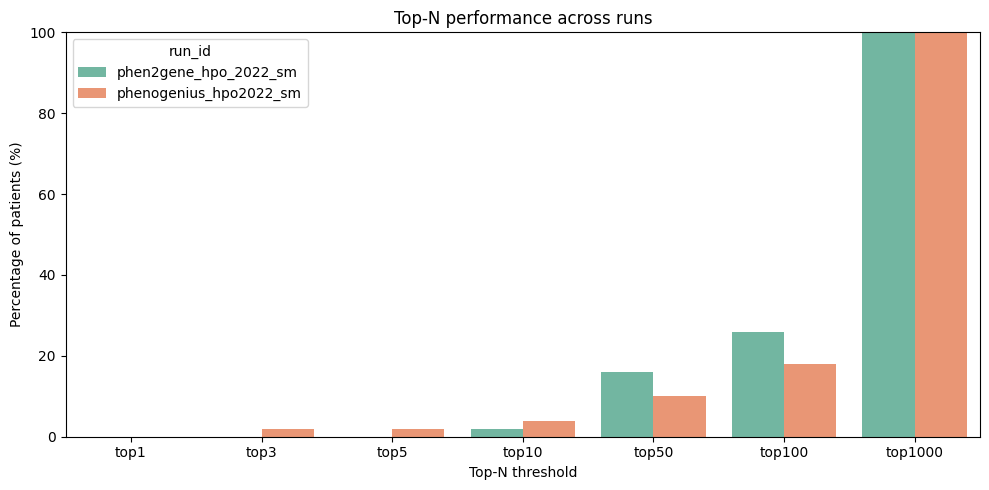

In [ ]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# seuils top-N que tu veux
thresholds = [1, 3, 5, 10, 50, 100, 1000]

def compute_topN_summary(df, thresholds):
    # groupby run_id puis on calcule, pour chaque seuil, le % de ranks <= seuil
    topN_summary = (
        df.groupby("run_id")["rank"]
          .apply(
              lambda s: pd.Series(
                  {f"top{n}": (s <= n).mean() * 100 for n in thresholds}
              )
          )
          .reset_index()
    )
    return topN_summary

topN_summary = compute_topN_summary(df, thresholds)
print(topN_summary)


palette = sns.color_palette("Set2")

# ordre des méthodes (si tu veux garder le même que dans rank_eval)
hue_order = rank_eval["run_id"].unique()
palette_map = {run_id: palette[i] for i, run_id in enumerate(hue_order)}
palette_hue = [palette_map[r] for r in hue_order]

plt.figure(figsize=(10, 5))

sns.barplot(
    data=topN_summary,
    x="level_1",           # top1, top3, top5...
    y="rank",              # pourcentage
    hue="run_id",
    hue_order=hue_order,
    palette=palette_hue,
    estimator="mean",      # ici chaque combinaison est unique, donc c'est juste une précaution
    errorbar=None          # ou ci=None selon ta version de seaborn
)

plt.xlabel("Top-N threshold")
plt.ylabel("Percentage of patients (%)")
plt.title("Top-N performance across runs")
plt.ylim(0, 100)
plt.tight_layout()

plt.savefig(OUTPUT_PATH + "top-N_performance_across_runs.png", dpi=300)
plt.show()
plt.close()

## Per run ranks distribution (boxplot)

/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_30786/2373719414.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_30786/2373719414.py:10: UserWarning:

The palette list has more values (8) than needed (2), which may not be intended.

/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_30786/2373719414.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_30786/2373719414.py:21: UserWarning:

The palette list has more values (8) than needed (2), which may not be intended.



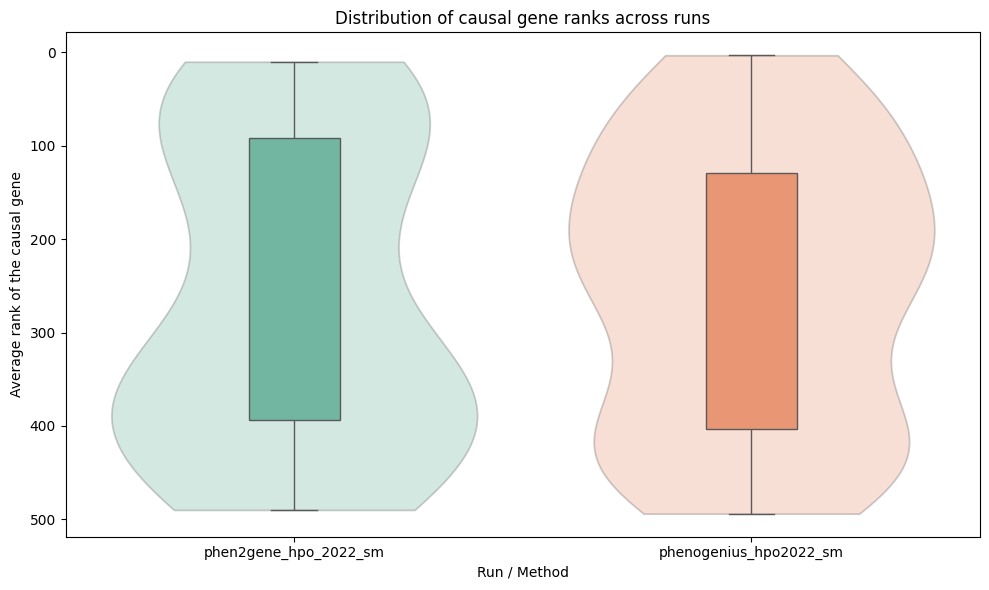

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# palette de couleurs pour réutiliser la même
palette = sns.color_palette("Set2")

# VIOLIN transparent
sns.violinplot(
    data=rank_eval,
    x="run_id",
    y="avg_rank",
    palette=palette,
    inner=None,
    cut=0,
    alpha=0.3,   # transparent
)

# BOX avec la même palette
sns.boxplot(
    data=rank_eval,
    x="run_id",
    y="avg_rank",
    whis=1.5,
    width=0.2,
    showcaps=True,
    showfliers=False,
    palette=palette,
    boxprops={'zorder': 3, 'alpha': 1},
)

plt.title("Distribution of causal gene ranks across runs")
plt.xlabel("Run / Method")
plt.ylabel("Average rank of the causal gene")

# inverser l’axe Y comme dans plotly
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "distribution_of_causal_gene_ranks_across_runs.png", dpi=300)
plt.show()
plt.close()

## Comparative CDF of ranks (Recall curves)

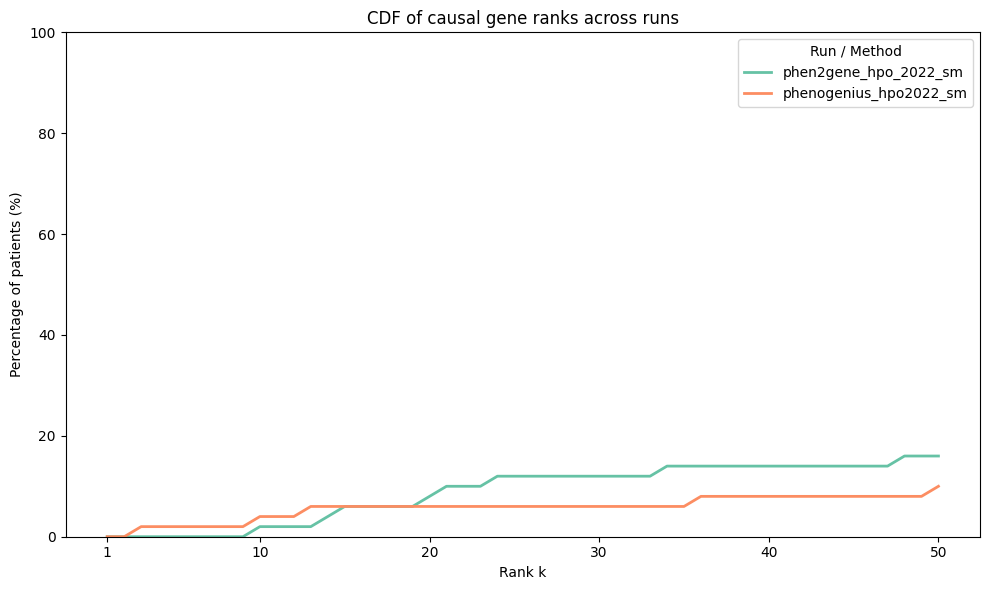

In [ ]:
k_max = 50
cdf_data = []

for run_id in rank_eval["run_id"].unique():
    sub = rank_eval[rank_eval["run_id"] == run_id]
    total = len(sub)
    if total == 0:
        continue
    for k in range(1, k_max + 1):
        pct = (sub["avg_rank"].notna() & (sub["avg_rank"] <= k)).sum() / total
        cdf_data.append({
            "run_id": run_id,
            "k": k,
            "percentage": pct * 100
        })

cdf_df = pd.DataFrame(cdf_data)



# même palette que dans le plot violin/box
palette = sns.color_palette("Set2")
palette_map = {run_id: palette[i] for i, run_id in enumerate(rank_eval["run_id"].unique())}

plt.figure(figsize=(10, 6))

for run_id in cdf_df["run_id"].unique():
    sub = cdf_df[cdf_df["run_id"] == run_id]
    plt.plot(
        sub["k"],
        sub["percentage"],
        label=run_id,
        color=palette_map[run_id],
        linewidth=2
    )

plt.title("CDF of causal gene ranks across runs")
plt.xlabel("Rank k")
plt.ylabel("Percentage of patients (%)")

plt.xticks([1, 10, 20, 30, 40, 50])
plt.ylim(0, 100)

plt.legend(title="Run / Method")
plt.tight_layout()

plt.savefig(OUTPUT_PATH + "cdf_of_causal_gene_ranks_across_runs.png", dpi=300)
plt.show()
plt.close()

## To add:

- Comparison at equal phenotype size (handling phenotypic size depends of HPO version too)
- Effect of phenotype specificity across runs
- Failure mode analysis per run
- ClinVar / ACMG stratified comparison
- Gene-centric difficulty across runs
- Inter-run concordance & stability
- Multivariate comparative model